In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
from google.cloud import bigquery

client = bigquery.Client(project="trelis-arc")

table_name = "trelis-arc.arc.fully_correct_100"
file_name = table_name.split('.')[-1]

In [3]:
create_final_table_query = f"""
CREATE OR REPLACE TABLE `{table_name}` AS

WITH arc_2_eval_tasks AS (
    SELECT DISTINCT task_id
    FROM `trelis-arc.arc.arc_task_ids`
    WHERE subset = "arc-agi-2/evaluation"
),
-- Clean programs by collapsing multiple empty lines into single empty lines
programs_cleaned AS (
    SELECT 
        k.task_id,
        -- Clean code by collapsing multiple consecutive newlines into at most one empty line
        -- Pattern matches multiple consecutive newlines with optional whitespace
        REGEXP_REPLACE(k.code, r'\\n(\\s*\\n)+', '\\n\\n') as code,
        k.model,
        k.predicted_train_output,
        k.predicted_test_output,
        k.correct_train_input,
        k.correct_test_input
    FROM `trelis-arc.arc.superking` k
    WHERE task_id NOT IN (SELECT task_id FROM arc_2_eval_tasks)
),
-- Calculate metrics and filter by grid size
programs_with_metrics AS (
    SELECT 
        task_id,
        code,
        model,
        predicted_train_output,
        predicted_test_output,
        correct_train_input,
        correct_test_input,
        LENGTH(code) as program_length,
        -- Check if all train inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) as all_train_correct,
        -- Check if all test inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as all_test_correct,
        -- Count correct examples
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) + 
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as total_correct,
        ARRAY_LENGTH(correct_train_input.list) + ARRAY_LENGTH(correct_test_input.list) as total_possible,
        -- Check grid sizes for train output
        (SELECT MAX(ARRAY_LENGTH(grid_2d.element.list)) 
         FROM UNNEST(predicted_train_output.list) AS grid_2d) as max_train_grid_height,
        (SELECT MAX(ARRAY_LENGTH(row_1d.element.list)) 
         FROM UNNEST(predicted_train_output.list) AS grid_2d,
              UNNEST(grid_2d.element.list) AS row_1d) as max_train_grid_width,
        -- Check grid sizes for test output
        (SELECT MAX(ARRAY_LENGTH(grid_2d.element.list)) 
         FROM UNNEST(predicted_test_output.list) AS grid_2d) as max_test_grid_height,
        (SELECT MAX(ARRAY_LENGTH(row_1d.element.list)) 
         FROM UNNEST(predicted_test_output.list) AS grid_2d,
              UNNEST(grid_2d.element.list) AS row_1d) as max_test_grid_width,
        -- Normalize code for deduplication (remove all whitespace, lowercase)
        LOWER(REGEXP_REPLACE(code, r'\\s+', '')) as normalized_code
    FROM programs_cleaned
),
-- Filter by grid size (40x40) and require ALL examples to be correct (fully correct only)
programs_filtered AS (
    SELECT *,
        -- Calculate success rate for ranking
        SAFE_DIVIDE(total_correct, total_possible) as success_rate
    FROM programs_with_metrics
    WHERE max_train_grid_height <= 40 AND max_train_grid_width <= 40
      AND max_test_grid_height <= 40 AND max_test_grid_width <= 40
      AND all_train_correct = TRUE AND all_test_correct = TRUE  -- Only fully correct programs
),
-- Find shortest, most correct program per task
task_benchmarks AS (
    SELECT 
        task_id,
        MIN(program_length) as shortest_best_length
    FROM (
        SELECT 
            task_id,
            program_length,
            ROW_NUMBER() OVER (
                PARTITION BY task_id 
                ORDER BY success_rate DESC, program_length ASC, code ASC
            ) as rank
        FROM programs_filtered
    ) ranked
    WHERE rank = 1
    GROUP BY task_id
),
-- Filter programs to those within 2.5x the shortest best program per task
programs_length_filtered AS (
    SELECT p.*
    FROM programs_filtered p
    INNER JOIN task_benchmarks b ON p.task_id = b.task_id
    WHERE p.program_length <= 2.5 * b.shortest_best_length
),
-- Deduplicate programs (same normalized code + task_id)
programs_deduplicated AS (
    SELECT 
        task_id, code, model, predicted_train_output, predicted_test_output,
        correct_train_input, correct_test_input, program_length, success_rate,
        ROW_NUMBER() OVER (
            PARTITION BY task_id, normalized_code
            ORDER BY success_rate DESC, program_length ASC, model ASC, code ASC
        ) as dedup_rank
    FROM programs_length_filtered
),
-- Take top 100 per task, prioritizing correctness then length
final_selection AS (
    SELECT 
        task_id, code, model, predicted_train_output, predicted_test_output,
        correct_train_input, correct_test_input,
        ROW_NUMBER() OVER (
            PARTITION BY task_id 
            ORDER BY success_rate DESC, program_length ASC, model ASC, code ASC
        ) as final_rank
    FROM programs_deduplicated
    WHERE dedup_rank = 1
)
SELECT task_id, code, model, predicted_train_output, predicted_test_output,
       correct_train_input, correct_test_input
FROM final_selection
WHERE final_rank <= 100
ORDER BY task_id, final_rank
"""

print("Executing BigQuery table creation...")
job = client.query(create_final_table_query)
result = job.result()
print(f"✓ Table `{table_name}` created successfully")

Executing BigQuery table creation...
✓ Table `trelis-arc.arc.fully_correct_100` created successfully
✓ Table `trelis-arc.arc.fully_correct_100` created successfully


In [4]:
from llm_python.datasets.bigquery_export import load_bigquery_table_as_dataframe

# Load BigQuery table as DataFrame using our reusable function
print("Loading BigQuery table data...")
raw_data = load_bigquery_table_as_dataframe(
    client=client,
    table_name=table_name
)
print(f"Loaded {len(raw_data)} programs from BigQuery table")

Loading BigQuery table data...
Exporting BigQuery table 'trelis-arc.arc.fully_correct_100' to GCS...
Waiting for BigQuery export to complete...
Waiting for BigQuery export to complete...
✓ Export to GCS completed successfully
✓ Export to GCS completed successfully
✓ Download completed
Reading parquet file...
✓ Download completed
Reading parquet file...
Loaded 20795 rows from BigQuery table
Loaded 20795 programs from BigQuery table
Loaded 20795 rows from BigQuery table
Loaded 20795 programs from BigQuery table


In [5]:
from llm_python.datasets.bigquery_converter import convert_bigquery_to_soar, save_soar_parquet

# First, let's inspect the actual data structure
print("Inspecting BigQuery data structure...")
sample_row = raw_data.iloc[0]
print(f"Sample row columns: {sample_row.index.tolist()}")
print(f"Train output type: {type(sample_row['predicted_train_output'])}")
print(f"Train correct type: {type(sample_row['correct_train_input'])}")

print("\n" + "="*50)

# Convert BigQuery data to SOAR format using our reusable function
print("Converting BigQuery data to SOAR format...")
final_dataset = convert_bigquery_to_soar(raw_data, show_progress=True)

# Save the final dataset
if len(final_dataset) > 0:
    output_path = f"/tmp/{file_name}.parquet"
    print(f"Saving final dataset to: {output_path}")
    
    save_soar_parquet(final_dataset, output_path)
else:
    print("No valid data to save!")

Inspecting BigQuery data structure...
Sample row columns: ['task_id', 'code', 'model', 'predicted_train_output', 'predicted_test_output', 'correct_train_input', 'correct_test_input']
Train output type: <class 'dict'>
Train correct type: <class 'dict'>

Converting BigQuery data to SOAR format...


Converting BQ to SOAR: 100%|██████████| 20795/20795 [00:02<00:00, 9149.53it/s] 



Successfully converted 20795 programs from 20795 input rows
Saving final dataset to: /tmp/fully_correct_100.parquet
PyArrow save failed ("name 'is_test_transductive' present in the specified schema is not found in the columns or index"), using pandas fallback
✓ Saved 20795 programs to /tmp/fully_correct_100.parquet with pandas
✓ Saved 20795 programs to /tmp/fully_correct_100.parquet with pandas


In [7]:
# Dataset Statistics Analysis (CORRECTED)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("="*80)
print("DATASET STATISTICS ANALYSIS")
print("="*80)

# 1. Basic counts - analyze the main table directly first
basic_stats_query = f"""
WITH correctness_analysis AS (
    SELECT 
        task_id,
        -- Check if all train inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) as all_train_correct,
        -- Check if all test inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as all_test_correct,
        -- Count correct examples
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) + 
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as total_correct,
        ARRAY_LENGTH(correct_train_input.list) + ARRAY_LENGTH(correct_test_input.list) as total_possible
    FROM `{table_name}`
)
SELECT 
    COUNT(DISTINCT task_id) as unique_tasks,
    COUNT(*) as total_programs,
    -- Correctness breakdown
    COUNTIF(all_train_correct AND all_test_correct) as fully_correct_programs,
    COUNTIF(total_correct > 0 AND NOT (all_train_correct AND all_test_correct)) as partially_correct_programs,
    COUNTIF(total_correct = 0) as completely_incorrect_programs,
    -- Average correctness rate
    AVG(SAFE_DIVIDE(total_correct, total_possible)) as avg_correctness_rate
FROM correctness_analysis
"""

print("1. Computing basic statistics...")
basic_stats = client.query(basic_stats_query).to_dataframe()
stats = basic_stats.iloc[0]

print(f"📊 Basic Statistics:")
print(f"   • Unique tasks: {stats['unique_tasks']:,}")
print(f"   • Total programs: {stats['total_programs']:,}")
print(f"   • Fully correct programs: {stats['fully_correct_programs']:,} ({100*stats['fully_correct_programs']/stats['total_programs']:.1f}%)")
print(f"   • Partially correct programs: {stats['partially_correct_programs']:,} ({100*stats['partially_correct_programs']/stats['total_programs']:.1f}%)")
print(f"   • Completely incorrect programs: {stats['completely_incorrect_programs']:,} ({100*stats['completely_incorrect_programs']/stats['total_programs']:.1f}%)")
print(f"   • Average correctness rate: {stats['avg_correctness_rate']:.3f}")

# 2. Get subset information (which subsets do our tasks belong to)
subset_query = f"""
WITH task_subsets AS (
    SELECT DISTINCT 
        d.task_id,
        t.subset
    FROM `{table_name}` d
    LEFT JOIN `trelis-arc.arc.arc_task_ids` t ON d.task_id = t.task_id
)
SELECT 
    subset,
    COUNT(DISTINCT task_id) as unique_tasks_in_subset
FROM task_subsets
WHERE subset IS NOT NULL
GROUP BY subset
ORDER BY subset
"""

subset_breakdown = client.query(subset_query).to_dataframe()
print(f"📋 ARC Subsets represented in dataset:")
for _, row in subset_breakdown.iterrows():
    print(f"   • {row['subset']}: {row['unique_tasks_in_subset']} tasks")

total_subset_tasks = subset_breakdown['unique_tasks_in_subset'].sum()
print(f"   • Note: Total adds to {total_subset_tasks} because some tasks appear in multiple subsets")

DATASET STATISTICS ANALYSIS
1. Computing basic statistics...


/home/lewis/code/trelis-arc/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


📊 Basic Statistics:
   • Unique tasks: 627.0
   • Total programs: 20,795.0
   • Fully correct programs: 20,795.0 (100.0%)
   • Partially correct programs: 0.0 (0.0%)
   • Completely incorrect programs: 0.0 (0.0%)
   • Average correctness rate: 1.000
📋 ARC Subsets represented in dataset:
   • arc-agi-1/evaluation: 196 tasks
   • arc-agi-1/training: 370 tasks
   • arc-agi-2/training: 610 tasks
   • Note: Total adds to 1176 because some tasks appear in multiple subsets
📋 ARC Subsets represented in dataset:
   • arc-agi-1/evaluation: 196 tasks
   • arc-agi-1/training: 370 tasks
   • arc-agi-2/training: 610 tasks
   • Note: Total adds to 1176 because some tasks appear in multiple subsets


In [8]:
# 2. Per-task program distribution analysis (CORRECTED)
print(f"\n2. Computing per-task distributions...")

per_task_query = f"""
WITH task_program_counts AS (
    SELECT 
        task_id,
        COUNT(*) as total_programs_per_task,
        -- Count correct programs per task
        COUNTIF(
            (SELECT LOGICAL_AND(correct_val.element) FROM UNNEST(correct_train_input.list) AS correct_val) AND
            (SELECT LOGICAL_AND(correct_val.element) FROM UNNEST(correct_test_input.list) AS correct_val)
        ) as fully_correct_per_task,
        -- Count partially correct programs per task
        COUNTIF(
            (SELECT COUNTIF(correct_val.element) FROM UNNEST(correct_train_input.list) AS correct_val) + 
            (SELECT COUNTIF(correct_val.element) FROM UNNEST(correct_test_input.list) AS correct_val) > 0
            AND NOT (
                (SELECT LOGICAL_AND(correct_val.element) FROM UNNEST(correct_train_input.list) AS correct_val) AND
                (SELECT LOGICAL_AND(correct_val.element) FROM UNNEST(correct_test_input.list) AS correct_val)
            )
        ) as partially_correct_per_task
    FROM `{table_name}`
    GROUP BY task_id
)
SELECT 
    task_id,
    total_programs_per_task,
    fully_correct_per_task,
    partially_correct_per_task,
    (total_programs_per_task - fully_correct_per_task - partially_correct_per_task) as incorrect_per_task
FROM task_program_counts
ORDER BY total_programs_per_task DESC, task_id
"""

per_task_df = client.query(per_task_query).to_dataframe()

print(f"📈 Per-task Statistics:")
print(f"   • Average programs per task: {per_task_df['total_programs_per_task'].mean():.1f}")
print(f"   • Median programs per task: {per_task_df['total_programs_per_task'].median():.1f}")
print(f"   • Min programs per task: {per_task_df['total_programs_per_task'].min()}")
print(f"   • Max programs per task: {per_task_df['total_programs_per_task'].max()}")
print(f"   • Tasks with 100 programs (max): {(per_task_df['total_programs_per_task'] == 100).sum()}")
print(f"   • Tasks with fully correct programs: {(per_task_df['fully_correct_per_task'] > 0).sum()}")
print(f"   • Tasks with no correct programs: {(per_task_df['fully_correct_per_task'] == 0).sum()}")

# 3. Programs per task quantile analysis (your requested query)
print(f"\n3. Computing quantile distribution of programs per task...")

quantile_query = f"""
WITH task_id_counts AS (
    SELECT
        task_id,
        COUNT(1) AS cnt
    FROM
        `{table_name}`
    GROUP BY
        1
),
quantiles_nested AS (
    SELECT
        APPROX_QUANTILES(cnt, 100) AS quantiles_array
    FROM
        task_id_counts
)
SELECT
    quantile_value
FROM
    quantiles_nested,
    UNNEST(quantiles_nested.quantiles_array) AS quantile_value
ORDER BY quantile_value
"""

quantiles_df = client.query(quantile_query).to_dataframe()
quantiles = quantiles_df['quantile_value'].values

print(f"📊 Programs per Task - Quantile Distribution:")
print(f"   • 0th percentile (min): {quantiles[0]}")
print(f"   • 25th percentile: {quantiles[25]}")
print(f"   • 50th percentile (median): {quantiles[50]}")
print(f"   • 75th percentile: {quantiles[75]}")
print(f"   • 90th percentile: {quantiles[90]}")
print(f"   • 95th percentile: {quantiles[95]}")
print(f"   • 99th percentile: {quantiles[99]}")
print(f"   • 100th percentile (max): {quantiles[100]}")


2. Computing per-task distributions...


/home/lewis/code/trelis-arc/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


📈 Per-task Statistics:
   • Average programs per task: 33.2
   • Median programs per task: 21.0
   • Min programs per task: 1
   • Max programs per task: 100
   • Tasks with 100 programs (max): 72
   • Tasks with fully correct programs: 627
   • Tasks with no correct programs: 0

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1
   • 25th percentile: 6
   • 50th percentile (median): 21
   • 75th percentile: 53
   • 90th percentile: 100
   • 95th percentile: 100
   • 99th percentile: 100
   • 100th percentile (max): 100
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1
   • 25th percentile: 6
   • 50th percentile (median): 21
   • 75th percentile: 53
   • 90th percentile: 100
   • 95th percentile: 100
   • 99th percentile: 100
   • 100th percentile (max): 100


/home/lewis/code/trelis-arc/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



4. Creating visualizations...


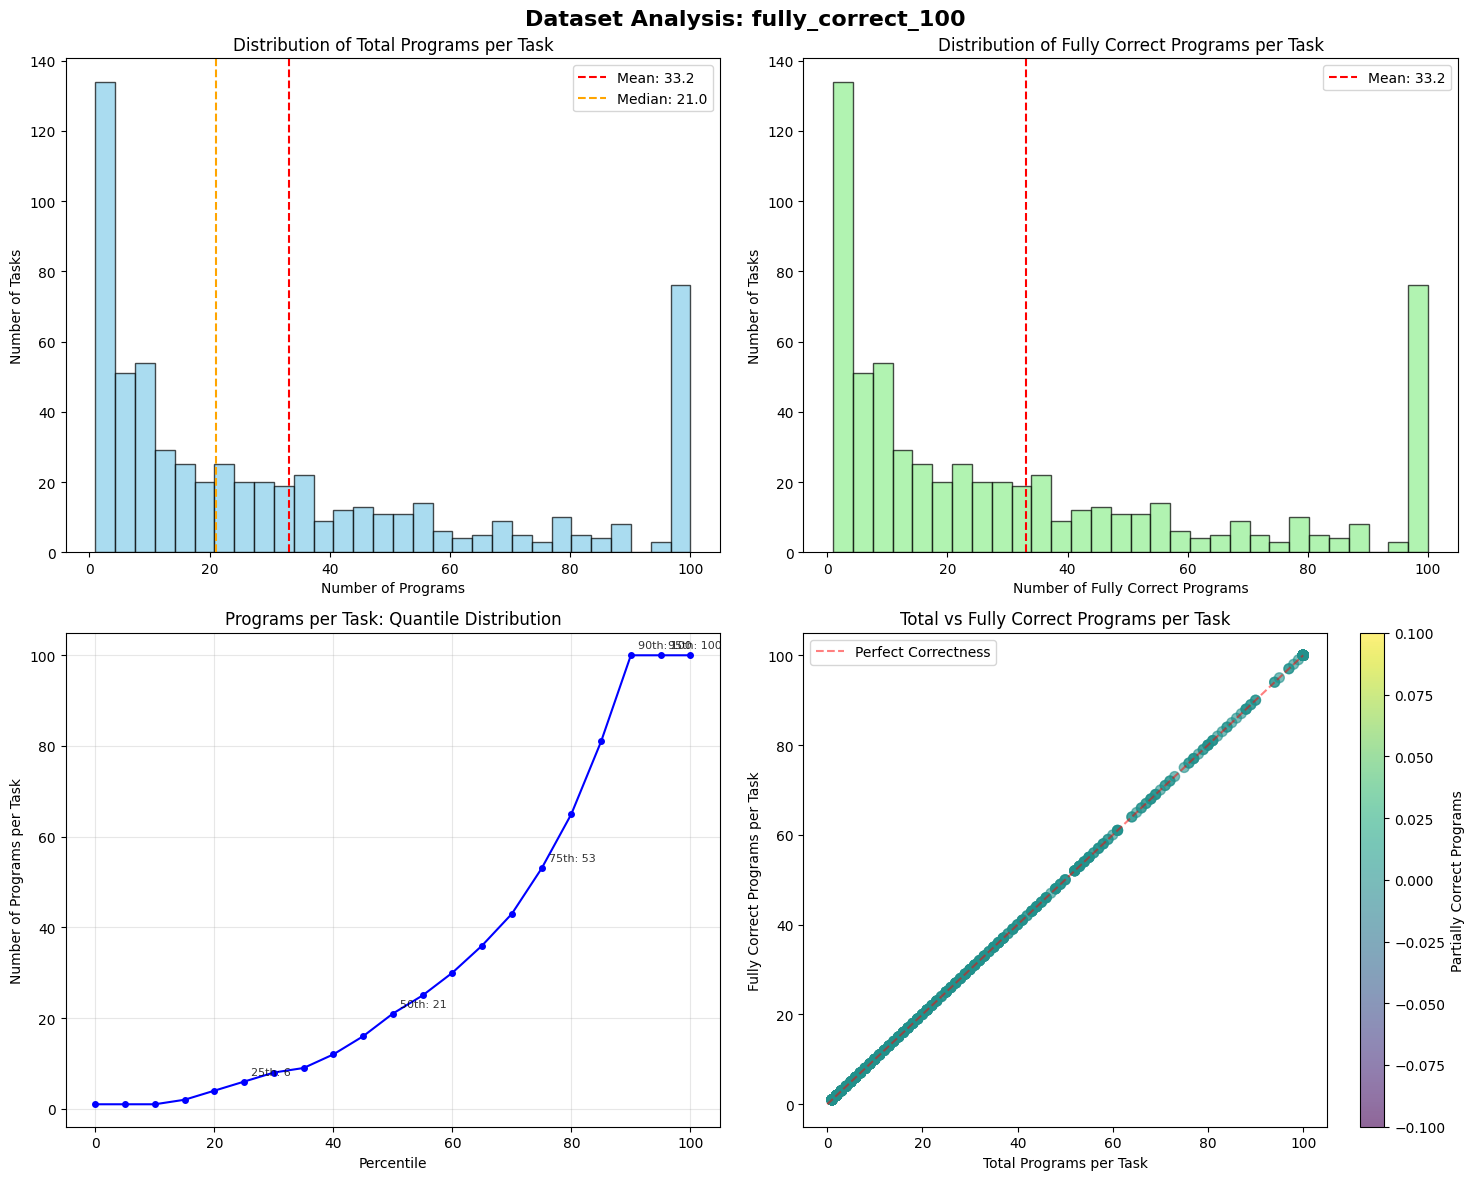


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task (your requested analysis)
   • Relationship between total and correct programs per task


In [9]:
# 4. Visualizations (UPDATED)
print(f"\n4. Creating visualizations...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Dataset Analysis: {file_name}', fontsize=16, fontweight='bold')

# 1. Distribution of total programs per task
axes[0, 0].hist(per_task_df['total_programs_per_task'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Total Programs per Task')
axes[0, 0].set_xlabel('Number of Programs')
axes[0, 0].set_ylabel('Number of Tasks')
axes[0, 0].axvline(per_task_df['total_programs_per_task'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {per_task_df["total_programs_per_task"].mean():.1f}')
axes[0, 0].axvline(per_task_df['total_programs_per_task'].median(), color='orange', linestyle='--', 
                   label=f'Median: {per_task_df["total_programs_per_task"].median():.1f}')
axes[0, 0].legend()

# 2. Distribution of fully correct programs per task
axes[0, 1].hist(per_task_df['fully_correct_per_task'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Fully Correct Programs per Task')
axes[0, 1].set_xlabel('Number of Fully Correct Programs')
axes[0, 1].set_ylabel('Number of Tasks')
axes[0, 1].axvline(per_task_df['fully_correct_per_task'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {per_task_df["fully_correct_per_task"].mean():.1f}')
axes[0, 1].legend()

# 3. Quantile distribution plot (your requested visualization)
percentiles = list(range(0, 101, 5))  # Every 5th percentile
quantile_values = [quantiles[p] for p in percentiles]

axes[1, 0].plot(percentiles, quantile_values, 'b-o', markersize=4)
axes[1, 0].set_title('Programs per Task: Quantile Distribution')
axes[1, 0].set_xlabel('Percentile')
axes[1, 0].set_ylabel('Number of Programs per Task')
axes[1, 0].grid(True, alpha=0.3)
# Add some key percentile annotations
for p in [25, 50, 75, 90, 95]:
    axes[1, 0].annotate(f'{p}th: {quantiles[p]}', 
                       xy=(p, quantiles[p]), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)

# 4. Scatter plot: total programs vs correct programs per task
scatter = axes[1, 1].scatter(per_task_df['total_programs_per_task'], 
                            per_task_df['fully_correct_per_task'],
                            alpha=0.6, c=per_task_df['partially_correct_per_task'], 
                            cmap='viridis', s=50)
axes[1, 1].set_title('Total vs Fully Correct Programs per Task')
axes[1, 1].set_xlabel('Total Programs per Task')
axes[1, 1].set_ylabel('Fully Correct Programs per Task')
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Partially Correct Programs')

# Add diagonal line for reference
max_val = max(per_task_df['total_programs_per_task'].max(), per_task_df['fully_correct_per_task'].max())
axes[1, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Correctness')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\n✓ Analysis complete! Generated visualizations showing:")
print(f"   • Program distribution patterns across tasks")
print(f"   • Quantile distribution of programs per task (your requested analysis)")
print(f"   • Relationship between total and correct programs per task")

In [6]:
import pandas as pd

from llm_python.utils.arc_tester import ArcTester
from llm_python.utils.task_loader import TaskLoader 
import random

df = pd.read_parquet("/tmp/fully_correct_100.parquet")

arc_tester = ArcTester()
task_loader  = TaskLoader()

sample_df = df.sample(n=100, random_state=random.randint(0, 100000))
for idx, row in sample_df.iterrows():
    res = arc_tester.test_program(row['code'], task_loader.get_task(row['task_id']))
    print(f"train-correct: {res.correct_train_input} test-correct: {res.correct_test_input}")

Loading arc-prize-2024...
  Training: 400 tasks
  Evaluation: 400 tasks
  Test: 100 tasks
Loading arc-prize-2025...
  Training: 1000 tasks
  Evaluation: 120 tasks
  Test: 240 tasks
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True, True, True] test-correct: [True, True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, True, True, True] test-correct: [True]
train-correct: [True, True, True] test-correct: [True]
train-correct: [True, Tru